In [23]:
"""
Script objectives:

Completed:
1) Copy 200 randomly selected images from test dir (cyberbullying, nsfw, or self_harm)
2) Zip the images to download locally (to allow the use of labelme on local machine)
3) extract the outputted labelme annotations

Todo:
4) Convert labelme annotation JSON files to ___

"""

import os
import glob
import random
import shutil
import json


# Assigning dir paths based on category
# 'cyberbullying' or 'nsfw' or 'self_harm'
category_choice = 4
category_dict_map = {
    0: 'cyberbullying',
    1: 'self_harm',
    2: 'nsfw',
    3: 'MNIST_71',
    4: 'MNIST_94',
    5: 'MNIST_80',
    6: 'MNIST_61',
    7: 'MNIST_sneaker_sandal',
    8: 'MNIST_shirt_t-shirt',
    9: 'MNIST_pullover_shirt',
    10: 'MNIST_boot_sneaker'
}

category = category_dict_map[category_choice]

#relative paths based on category
labelme_annotation_path = os.path.join(category, 'labelme_annotations')
converted_annotation_path = os.path.join(category, 'converted_annotations')

# #aboslute paths based on category
# image_path = os.path.join('/workspace/adv_robustness/cyberbullying_purification/samuel_src/datasets/', 
#                           category, 'test', category_dict_map[category_choice])

labelme_path = os.getcwd()
# labelme_path

In [24]:
# selecting 200 image names from test folder, 
# and copying them to labelme dir (if they don't already exist)

# grabbing all image names
# os.chdir(image_path)
# images_str_list = glob.glob('*')
# os.chdir(labelme_path)

# num_images = 200
# random.seed(42) # for replication
# random_numbers_list = random.sample(range(len(images_str_list)), num_images)

# # copying over randomly selected images to "./" + category
# for num in random_numbers_list:
#     source_path = os.path.join(image_path, images_str_list[num])
#     destination_path = os.path.join(labelme_path, category, 'test_images',images_str_list[num])
#     # making sure the file is not already present, so no duplicated images if re-run
#     if not(os.path.exists(destination_path)):
#         shutil.copy(source_path, destination_path)

# # checking for 200 images
# len(glob.glob(category + '/test_images/*'))

In [25]:
# creating zip of test images for downloading to use labelme on local machine
zip_path = 'test_images'

os.chdir(category)
if not(os.path.exists(category + '_' + zip_path + '.zip')):
    shutil.make_archive(category + '_' + zip_path, 'zip', zip_path)
else:
    print('That zip already exists!')
os.chdir(labelme_path)


In [4]:
# extracting labelme_annotations.zip to labelme_annotations dir
zip_path = os.path.join(category)
zip_file = os.path.join(category, 'labelme_annotations.zip')
current_images_in_dir = bool(glob.glob(os.path.join(zip_path, 'labelme_annotations/*')))

if not(current_images_in_dir):
    shutil.unpack_archive(zip_file, zip_path,'zip')
else:
    print('Something is already extracted here!')


In [10]:
json_annotations = list(dict())

# changing dir to annotation folder
os.chdir(os.path.join(labelme_path, category, 'labelme_annotations'))
json_file_names = glob.glob('*')

for json_file_name in json_file_names:
    with open(json_file_name) as json_file:
        json_annotations.append(json.load(json_file))
        
# changing dir back to labelme root folder
os.chdir(labelme_path)

json_annotations[100]

{'version': '5.1.1',
 'flags': {},
 'shapes': [{'label': 'cb',
   'points': [[549.6818181818182, 220.18181818181822],
    [498.7727272727273, 167.45454545454547],
    [480.5909090909092, 167.45454545454547],
    [507.86363636363643, 202.00000000000003],
    [480.5909090909092, 214.72727272727275],
    [429.6818181818182, 229.27272727272728],
    [442.40909090909093, 242.00000000000003],
    [480.5909090909092, 247.45454545454547],
    [491.50000000000006, 269.2727272727273],
    [513.3181818181818, 280.18181818181824],
    [536.9545454545455, 276.5454545454546]],
   'group_id': None,
   'shape_type': 'polygon',
   'flags': {}}],
 'imagePath': '..\\test_images\\1f6df12adee14b9e9a5d53d48ea6b6bd.jpg',
 'imageData': None,
 'imageHeight': 1024,
 'imageWidth': 683}

In [6]:
points_test = json_annotations[100]['shapes'][0]['points']
image_size = (json_annotations[100]['imageWidth'], json_annotations[100]['imageHeight'])
image_name = json_annotations[100]['imagePath'].split('\\')[-1]

print('image name:', image_name)
print('image dim:', image_size)

print('polygon points:')
for xy in points_test:
    print(xy)

image name: 1f6df12adee14b9e9a5d53d48ea6b6bd.jpg
image dim: (683, 1024)
polygon points:
[549.6818181818182, 220.18181818181822]
[498.7727272727273, 167.45454545454547]
[480.5909090909092, 167.45454545454547]
[507.86363636363643, 202.00000000000003]
[480.5909090909092, 214.72727272727275]
[429.6818181818182, 229.27272727272728]
[442.40909090909093, 242.00000000000003]
[480.5909090909092, 247.45454545454547]
[491.50000000000006, 269.2727272727273]
[513.3181818181818, 280.18181818181824]
[536.9545454545455, 276.5454545454546]


In [46]:
from PIL import Image, ImageDraw
import numpy as np
from torchvision import transforms
import torch
import json
import os

In [47]:
def labelme_json_annotation_loader(annotation_path: str, transforms=None):
    """Loads in json annotation polygons generated by Labelme. 
       Returns numpy array if no transforms are specified.
    """
    json_annotations = None
    with open(annotation_path) as json_file:
        json_annotations = json.load(json_file)
    
    image_size = (json_annotations['imageWidth'], json_annotations['imageHeight'])
    new_img = Image.new('L', image_size, 'black')
    new_img1 = ImageDraw.Draw(new_img)
    
    number_of_polygons = len(json_annotations['shapes'])
    for i in range(number_of_polygons):
        points = json_annotations['shapes'][i]['points']
        # points is a list[list[]] by default, it needs to be tuple[tuple[]]
        for i in range(len(points)):
            points[i] = tuple(points[i])
        points = tuple(points)
        new_img1.polygon(points, fill="white")
    
    # If no transforms are given, new_img is returned as np array
    if transforms:
        return transforms(new_img)
    else:
        return np.array(new_img)

torch.Size([1, 299, 299])
torch.Size([3, 299, 299])


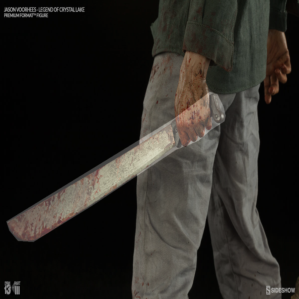

In [48]:
# verifying that the function works
# overlaying img annotations with the an original image to make sure that the transformations do not
# mess up where the annotations polygons should be

# getting anotation tensor
annotation_path_test = os.path.join('/workspace/adv_robustness/region_explainability/labelme/cyberbullying',
                                    'labelme_annotations/0234e45059614204a5a81f5464a3b54d.json')

transform_test = transforms.Compose([transforms.Resize((299,299)), transforms.ToTensor()])
annotation_test_tensor = labelme_json_annotation_loader(annotation_path_test, transforms=transform_test)

# getting original image and performing the same transformations that were preformed on annotations
image_path_test = os.path.join('/workspace/adv_robustness/region_explainability/labelme/cyberbullying',
                               'test_images/0234e45059614204a5a81f5464a3b54d.jpg')
original_image_tensor = transform_test(Image.open(image_path_test))

# verifying that both transformed images are the same shape
print(annotation_test_tensor.shape)
print(original_image_tensor.shape)

# transforming tensors back into PIL Images to blend them together
transform_toPIL = transforms.ToPILImage()
annotation_img = transform_toPIL(annotation_test_tensor).convert('RGBA')
original_img = transform_toPIL(original_image_tensor).convert('RGBA')

# combining the original image and the annotation tensor to see if they match
combined_img = Image.blend(original_img, annotation_img, 0.25)
combined_img.show()

In [49]:
# globbing all annotations

import glob
import os
from IPython.display import clear_output

# categories = 'cyberbullying' or 'nsfw' or 'self_harm'

base_path = os.path.join('/workspace/adv_robustness/region_explainability/labelme/')
test_category = 'cyberbullying'
annotation_folder_path = os.path.join(base_path, test_category, 'labelme_annotations')
image_folder_path = os.path.join(base_path, test_category, 'test_images')
annotation_file_names = [file_name.split('/')[-1] for file_name in glob.glob(os.path.join(annotation_folder_path ,'*'))]


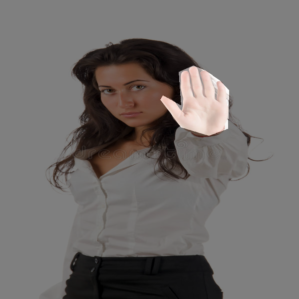

/workspace/adv_robustness/region_explainability/labelme/cyberbullying/test_images/4dc59e2be9084d5085b9d345165c0d6b.JPEG


type 'q' to end, enter to continue q


In [50]:
for json_file in annotation_file_names:
    annotation_path_test = os.path.join(annotation_folder_path, json_file)
    
    json_annotations = None
    with open(annotation_path_test) as json_file:
        json_annotations = json.load(json_file)
    
    image_path_test = os.path.join(image_folder_path, json_annotations['imagePath'].split('\\')[-1])
    
    annotation_test_tensor = labelme_json_annotation_loader(annotation_path_test, transforms=transform_test)
    original_image_tensor = transform_test(Image.open(image_path_test))

    # transforming tensors back into PIL Images to blend them together
    transform_toPIL = transforms.ToPILImage()
    annotation_img = transform_toPIL(annotation_test_tensor).convert('RGBA')
    original_img = transform_toPIL(original_image_tensor).convert('RGBA')

    # combining the original image and the annotation tensor to see if they match
    combined_img = Image.blend(original_img, annotation_img, 0.5)
    combined_img.show()
    print(image_path_test)
    cancel = input("type 'q' to end, enter to continue")
    if cancel:
        break
    clear_output(wait=True)
